# Step 3: Data Cleaning & Feature Engineering (Modify Stage)

In [42]:
# Install the required packages
## !pip -q install pycaret[full]
## !pip -q install dataprep
## !pip install matplotlib seaborn
## !pip install scikit-learn==1.2.2
## !pip install imblearn

In [43]:
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

df = pd.read_csv("./data/stroke_data.csv")
df.columns = ["id", "gender", "age", "hypertension",	"heart_disease",
              "ever_married", "work_type", "residence_type", "avg_glucose_level",
              "bmi", "smoking_status", "stroke"]

# Assign data type to the columns
df["hypertension"] = df["hypertension"].astype("int")
df["heart_disease"] = df["heart_disease"].astype("int")

# drop id column
df = df.drop(columns=["id"])


In [44]:
# define categorical and numerical columns

numerical_var = ["age", "average_glucose_level", "bmi"]
categorical_var = ["gender", "hypertension", "heart_disease", "ever_married", "work_type", "smoking_status"]
target_var = ["stroke"]

In [45]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


### (i) Train Test split

Data Cleaning Strategy to Prevent Data Leakage:

1. Split Data First, Clean Second
   - We will perform train-test split before any data preprocessing or cleaning
   - This ensures complete separation between training and test data

2. Why This Matters:
   - Data leakage occurs when test set information influences model training
   - Processing data before splitting can cause subtle forms of leakage
   - Example: If we one-hot encode categories using the full dataset:
     * The model gains knowledge of all possible categories, including those only present in the test set
     * This creates unrealistically good performance metrics since the model has "seen" information it shouldn't have access to

In [46]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Split the dataset using stratification
X = df.drop(columns='stroke', axis=1)  # Features
y = df['stroke']  # Target

X_train, X_test, y_train, y_test = train_test_split(
          X, y, test_size=0.2, stratify=y, random_state=42)

# combine X_train and y_train data
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

### (ii) Missing Value Imputation for `bmi` column

- `bmi`

  - **Type of missing value**: MAR 
  - **Explanation**: The missingness depends on observed variables like gender and age group, etc, and not on the value of the `bmi` itself
  - **Other observation**: 3% of the data is missing
  - **Approach**: 
      - Implement group-based imputation based using other columns in the dataset
      - Create missingness indicator variable named `bmi_missing`

In [47]:
# check missing values in `bmi` column

## Check missing values in the training set
print("\nMissing values of `bmi` column in the training set X_train:", X_train["bmi"].isnull().sum())

## Check missing values in the test set
print("\nMissing values of `bmi` column in the test set X_test:", X_test["bmi"].isnull().sum())


Missing values of `bmi` column in the training set X_train: 170

Missing values of `bmi` column in the test set X_test: 31


In [48]:
train_data

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
845,Female,48.0,0,0,Yes,Private,Urban,69.21,33.1,never smoked,0
3744,Male,15.0,0,0,No,Private,Rural,122.25,21.0,never smoked,0
4183,Female,67.0,0,0,Yes,Self-employed,Rural,110.42,24.9,never smoked,0
3409,Male,44.0,0,0,Yes,Private,Urban,65.41,24.8,smokes,0
284,Male,14.0,0,0,No,Govt_job,Urban,82.34,31.6,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...
1434,Female,45.0,0,0,Yes,Private,Urban,92.86,35.1,formerly smoked,0
461,Female,16.0,0,0,No,children,Rural,113.47,19.5,Unknown,0
1052,Female,61.0,0,0,Yes,Private,Rural,78.65,36.2,formerly smoked,0
1757,Male,31.0,0,0,Yes,Private,Urban,74.05,26.0,Unknown,0


- Checking the distribution of missing values in `bmi` column, grouped by target variable `stroke` for train_data

In [49]:
print(train_data.groupby('stroke')["bmi"].apply(lambda x: x.isna().sum()))

stroke
0    133
1     37
Name: bmi, dtype: int64


- Checking if missing values in `bmi` column is dependent to other categorical variables for the whole dataset

In [50]:
from scipy import stats

data = df.copy(deep=True)

## Binning age group from numerical to categorical variable to perform
age_bins = [0, 11, 21, 41, 61, 80, 100]
age_labels = ["Infants/Children", "Teens", "Young Adults", "Middle Age", "Seniors", "Advanced Seniors"]
data["age_group"] = pd.cut(data["age"], bins=age_bins, labels=age_labels, right=False, ordered=True)


# Create missingness indicator
data['bmi_missing'] = data['bmi'].isna().astype(int)

for var in categorical_var + ['age_group']:
  # Chi-square test for gender
  # chi2_contingency returns: (chi2 statistic, p-value, degrees of freedom, expected frequencies)
  chi2_stat, p_value, dof, expected = stats.chi2_contingency(pd.crosstab(data[var], data['bmi_missing']))
  print(f"""{var} 
        - Chi-square statistic: {chi2_stat:.4f}; p-value: {p_value:.4f}; 
        - Significance association between missing values in bmi and {var}: {bool(p_value < 0.01)}\n""")

gender 
        - Chi-square statistic: 9.2704; p-value: 0.0097; 
        - Significance association between missing values in bmi and gender: True

hypertension 
        - Chi-square statistic: 42.6409; p-value: 0.0000; 
        - Significance association between missing values in bmi and hypertension: True

heart_disease 
        - Chi-square statistic: 47.4808; p-value: 0.0000; 
        - Significance association between missing values in bmi and heart_disease: True

ever_married 
        - Chi-square statistic: 6.3337; p-value: 0.0118; 
        - Significance association between missing values in bmi and ever_married: False

work_type 
        - Chi-square statistic: 10.1329; p-value: 0.0382; 
        - Significance association between missing values in bmi and work_type: False

smoking_status 
        - Chi-square statistic: 36.5172; p-value: 0.0000; 
        - Significance association between missing values in bmi and smoking_status: True

age_group 
        - Chi-square statisti

In [63]:
# Implement group-based imputation

from scripts.group_imputer import GroupImputer

# convert numerical variables: `age` into categorical variable: `age_group`
age_bins = [0, 11, 21, 41, 61, 80, 100]
age_labels = ["Infants/Children", "Teens", "Young Adults", "Middle Age", "Seniors", "Advanced Seniors"]
X_train["age_group"] = pd.cut(X_train["age"], bins=age_bins, labels=age_labels, right=False, ordered=True)
X_test["age_group"] = pd.cut(X_test["age"], bins=age_bins, labels=age_labels, right=False, ordered=True)

# Create missingness indicator for bmi_column
X_train['bmi_missing'] = X_train['bmi'].isna().astype(int)
X_test['bmi_missing'] = X_test['bmi'].isna().astype(int)

# impute the grouped data by mean
imp = GroupImputer(group_cols=['age_group','heart_disease', 
                               'hypertension', 
                               'smoking_status', 'gender'], 
                   target='bmi', # filling missing values in `bmi` column
                   metric='mean')

# impute it by group-based imputation
X_train_imp = pd.DataFrame(imp.fit_transform(X_train),
                              columns = X_train.columns,
                              index=X_train.index)
X_test_imp = pd.DataFrame(imp.fit_transform(X_test),
                             columns = X_test.columns,
                             index=X_test.index)

In [52]:
# check missing values in `bmi` column

## Check missing values in the training set
print("\nMissing values of `bmi` column in the training set X_train:", X_train_imp["bmi"].isnull().sum())

## Check missing values in the test set
print("\nMissing values of `bmi` column in the test set X_test:", X_test_imp["bmi"].isnull().sum())


Missing values of `bmi` column in the training set X_train: 3

Missing values of `bmi` column in the test set X_test: 2


In [60]:
X_train.shape
y_train.shape

(4088,)

In [70]:
## since we've implement group-based imputation, and the count of missing value is reduced to single-digit, we would simply drop these missing rows

train_data_imp = pd.concat([X_train_imp, y_train], axis=1)
test_data_imp = pd.concat([X_test_imp, y_test], axis=1)

train_data_imp.dropna(inplace=True)
test_data_imp.dropna(inplace=True)

In [71]:
# check missing values in `bmi` column

## Check missing values in the training set
print("\nMissing values of `bmi` column in the training set X_train:", train_data_imp["bmi"].isnull().sum())

## Check missing values in the test set
print("\nMissing values of `bmi` column in the test set X_test:", test_data_imp["bmi"].isnull().sum())


Missing values of `bmi` column in the training set X_train: 0

Missing values of `bmi` column in the test set X_test: 0


In [75]:
print("The train data's dimension:", train_data_imp.shape)
print("The test data's dimension: ", test_data_imp.shape)

The train data's dimension: (4085, 13)
The test data's dimension:  (1020, 13)


### (iii) One-hot encoding

In [76]:
# apply one-hot encoding to the train dataset
train_data_encoded = train_data_imp[['gender', 'age', 'hypertension', 'heart_disease',
           'ever_married', 'work_type', 'residence_type',	'avg_glucose_level',
           'bmi',	'smoking_status','stroke']].copy(deep=True)


train_data_encoded["ever_married"] = train_data_encoded["ever_married"].map({"Yes": 1, "No": 0})
train_data_encoded = pd.get_dummies(train_data_encoded, columns=['gender', 'smoking_status',
                                'work_type', 'residence_type'],
                              drop_first=True)

# apply one-hot encoding to the test dataset
test_data_encoded = test_data_imp[['gender', 'age', 'hypertension', 'heart_disease',
           'ever_married', 'work_type', 'residence_type',	'avg_glucose_level',
           'bmi',	'smoking_status','stroke']].copy(deep=True)


test_data_encoded["ever_married"] = test_data_encoded["ever_married"].map({True: 1, False: 0})
test_data_encoded = pd.get_dummies(test_data_encoded, columns=['gender', 'smoking_status',
                                'work_type', 'residence_type'],
                              drop_first=True)

### (iv) SMOTE re-sampling

In [79]:
# Apply SMOTE to the training set
from imblearn.over_sampling import SMOTE

X_train_encoded = train_data_encoded.drop(columns='stroke')
y_train_encoded = train_data_encoded['stroke']
y_train_encoded = train_data_encoded['stroke']

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_encoded, y_train_encoded)

# Concatenate X_train_res and y_train_res to form train_data
train_data_res = pd.concat([X_train_res, y_train_res], axis=1)

# Concatenate X_test and y_test to form test_data
test_data = pd.concat([X_test, y_test], axis=1)

## Modeling

### (i) Simple decision tree model as a benchmark

In [ ]:
from pycaret.classification import *

dt_experiment = setup(data=train_data_res,
                      target="stroke",
                      test_data=test_data,
                      session_id=24, # seed config to ensure experiment's reproducility
                      preprocess=False, # since we've manually do the feature engineering
                      normalize=True,
                      normalize_method = 'zscore',
                      experiment_name = "dt_stroke_classification",
                      index=False)
dt_model = create_model('dt', fold=5)

type(dt_model)

ModuleNotFoundError: No module named 'pycaret'

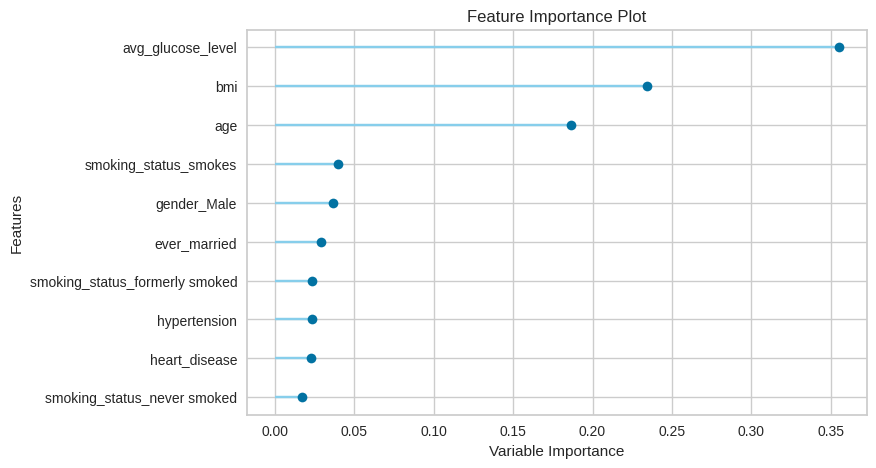

In [46]:
plot_model(dt_model,"feature")

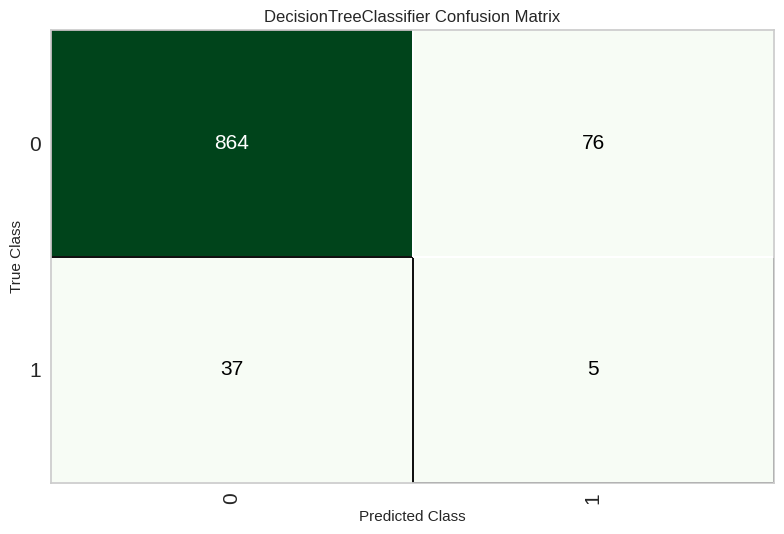

In [21]:
plot_model(dt_model,"confusion_matrix")

In [22]:
# Plot Decision Tree
plot_model(dt_model, plot="parameter")
print(dt_model)

,Parameters
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,None
max_features,None
max_leaf_nodes,None
min_impurity_decrease,0.0
min_samples_leaf,1
min_samples_split,2
min_weight_fraction_leaf,0.0


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, random_state=24, splitter='best')


In [23]:
# pull the other metrics for this decision tree model
metrics_df = pull()  # Pulls cross-validation metrics
print(metrics_df)  # This will be a pandas DataFrame

      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.8830  0.8830  0.8471  0.9126  0.8786  0.7660  0.7679
1       0.9262  0.9262  0.9747  0.8885  0.9296  0.8524  0.8564
2       0.9375  0.9375  0.9734  0.9082  0.9397  0.8750  0.8773
3       0.9422  0.9422  0.9628  0.9246  0.9433  0.8843  0.8851
4       0.9402  0.9402  0.9707  0.9148  0.9419  0.8803  0.8820
Mean    0.9258  0.9258  0.9457  0.9097  0.9266  0.8516  0.8537
Std     0.0221  0.0221  0.0495  0.0119  0.0245  0.0442  0.0440


In [24]:
# Get the evaluation metrics of the test set in the decision tree model
predictions = predict_model(dt_model, data=test_data)
holdout_score = pull() # Pulls test set's evaluation metrics
type(holdout_score)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.8849,0.5191,0.1190,0.0617,0.0813,0.0265,0.0281


pandas.core.frame.DataFrame

In [25]:
# create boosting ensemble models with just one line of code.
bagging_dt = ensemble_model(dt_model, method="Bagging")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8271,0.9228,0.7074,0.9301,0.8036,0.6543,0.6738
1,0.9588,0.9914,0.9787,0.9412,0.9596,0.9176,0.9183
2,0.9521,0.9895,0.9734,0.9337,0.9531,0.9043,0.9051
3,0.9601,0.9933,0.9814,0.9413,0.9609,0.9202,0.9210
4,0.9588,0.9858,0.9840,0.9367,0.9598,0.9176,0.9187
5,0.9654,0.9931,0.9707,0.9605,0.9656,0.9309,0.9309
6,0.9681,0.9954,0.9681,0.9681,0.9681,0.9362,0.9362
7,0.9694,0.9967,0.9787,0.9608,0.9697,0.9388,0.9390
8,0.9668,0.9944,0.9920,0.9443,0.9676,0.9335,0.9347


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [26]:
boosting = ensemble_model(dt_model, method= 'Boosting')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8285,0.8285,0.7261,0.9130,0.8089,0.6569,0.6711
1,0.9428,0.9428,0.9734,0.9173,0.9445,0.8856,0.8873
2,0.9375,0.9375,0.9734,0.9082,0.9397,0.8750,0.8773
3,0.9269,0.9269,0.9628,0.8983,0.9294,0.8537,0.8559
4,0.9428,0.9428,0.9654,0.9237,0.9441,0.8856,0.8865
5,0.9388,0.9388,0.9707,0.9125,0.9407,0.8777,0.8795
6,0.9548,0.9548,0.9628,0.9476,0.9551,0.9096,0.9097
7,0.9574,0.9574,0.9681,0.9479,0.9579,0.9149,0.9151
8,0.9402,0.9402,0.9707,0.9148,0.9419,0.8803,0.8820


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

## AutoML

In [ ]:
# Use these splits in PyCaret
from pycaret.classification import *
automl_experiment = setup(data=train_data_res,
                          target="stroke",
                          test_data=test_data,
                          fix_imbalance=False, # since we manually oversampling via SMOTE during train-test split
                          session_id=24, # seed config to ensure experiment's reproducility
                          preprocess=False, # since we've manually do the feature engineering
                          experiment_name = "automl_stroke_classification",
                          fold=10,
                          index=False)

# get a list of top 3 models
best_model = compare_models(sort="F1")

# generate logs
get_logs()

,Description,Value
0,Session id,24
1,Target,stroke
2,Target type,Binary
3,Original data shape,"(8502, 17)"
4,Transformed data shape,"(8502, 17)"
5,Transformed train set shape,"(7520, 17)"
6,Transformed test set shape,"(982, 17)"
7,Numeric features,16


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:39:29
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Light Gradient Boosting Machine


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9581,0.9923,0.9668,0.9503,0.9566,0.9162,0.9191,0.1160
rf,Random Forest Classifier,0.9572,0.9926,0.9654,0.9494,0.9556,0.9144,0.9170,0.4210
et,Extra Trees Classifier,0.9537,0.9904,0.9633,0.9450,0.9518,0.9074,0.9109,0.3050
dt,Decision Tree Classifier,0.9322,0.9322,0.9444,0.9217,0.9314,0.8644,0.8669,0.0340
gbc,Gradient Boosting Classifier,0.9133,0.9712,0.9322,0.8985,0.9129,0.8266,0.8304,0.4790
knn,K Neighbors Classifier,0.8939,0.9567,0.9782,0.8373,0.9022,0.7878,0.7995,0.0690
ada,Ada Boost Classifier,0.8863,0.9578,0.8984,0.8774,0.8850,0.7726,0.7764,0.1830
ridge,Ridge Classifier,0.8771,0.9479,0.8854,0.8710,0.8760,0.7543,0.7572,0.0240
lda,Linear Discriminant Analysis,0.8770,0.9479,0.8854,0.8708,0.8758,0.7540,0.7569,0.0240
lr,Logistic Regression,0.8711,0.9485,0.8747,0.8685,0.8697,0.7423,0.7448,0.1930


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [36]:
# get the pipeline
best_model_pipeline = get_config("pipeline")
best_model_pipeline

Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('clean_column_names',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=CleanColumnNames(match='[\\]\\[\\,\\{\\}\\"\\:]+')))],
         verbose=False)

In [37]:
# hyperparameter tuning
tuned_best_model = tune_model(best_model, fold=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8178,0.9166,0.7660,0.8546,0.8079,0.6356,0.6391
1,0.9043,0.9905,0.9973,0.8408,0.9124,0.8085,0.8229
2,0.8790,0.9780,0.9973,0.8065,0.8918,0.7580,0.7801
3,0.9122,0.9876,0.9920,0.8555,0.9187,0.8245,0.8352
4,0.9122,0.9826,0.9973,0.8523,0.9191,0.8245,0.8367
5,0.9202,0.9856,0.9947,0.8657,0.9257,0.8404,0.8499
6,0.9202,0.9846,0.9947,0.8657,0.9257,0.8404,0.8499
7,0.9096,0.9882,0.9947,0.8500,0.9167,0.8191,0.8313
8,0.9136,0.9875,1.0000,0.8526,0.9204,0.8271,0.8398


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [38]:
# making prediction
predictions = predict_model(tuned_best_model, data = test_data_resampled)
predictions

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9114,0.7504,0.1190,0.0909,0.1031,0.0574,0.0580


,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,gender_Male,gender_Other,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Urban,stroke,prediction_label,prediction_score
0,57.0,0,0,1,189.570007,30.700001,1,0,0,1,0,0,1,0,0,1,0,0,0.9895
1,49.0,0,0,1,78.339996,32.500000,1,0,0,0,0,0,1,0,0,0,0,0,0.9853
2,25.0,0,0,1,65.599998,33.500000,0,0,0,1,0,0,1,0,0,1,0,0,0.9999
3,37.0,0,0,1,73.500000,26.100000,0,0,1,0,0,0,1,0,0,0,0,0,0.9682
4,14.0,0,0,0,161.279999,19.100000,1,0,0,0,0,1,0,0,0,0,0,0,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977,25.0,0,0,0,78.589996,37.200001,0,0,0,1,0,0,1,0,0,1,0,0,0.9998
978,15.0,0,0,0,77.550003,24.799999,1,0,0,0,0,0,1,0,0,1,0,0,0.9997
979,37.0,0,0,1,203.809998,46.599998,0,0,0,1,0,0,1,0,0,1,0,0,1.0000
980,43.0,0,0,1,110.419998,32.599998,0,0,0,0,1,0,1,0,0,1,0,0,0.9994


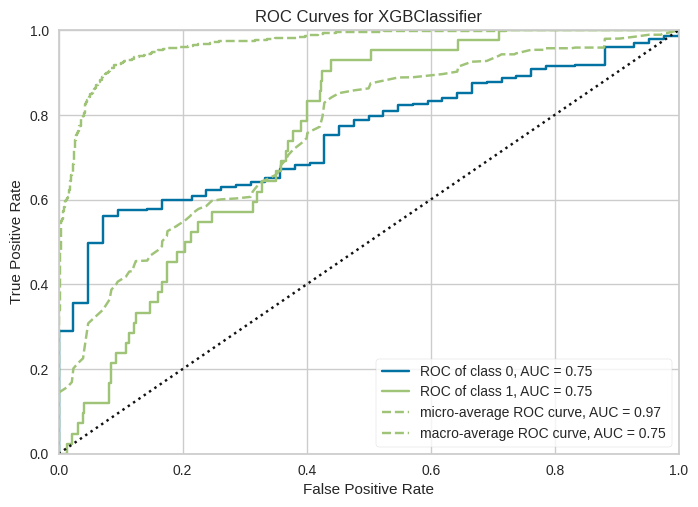

In [39]:
plot_model(tuned_best_model, plot="auc")

In [40]:
plot_model(tuned_best_model, plot='class_report')

TypeError: plot_model() got an unexpected keyword argument 'data'

In [ ]:
plot_model(tuned_best_model, plot="confusion_matrix", data=test_data)

In [ ]:
plot_model(tuned_best_model, plot='feature', data=test_data)

In [ ]:
evaluate_model(tuned_best_model, data=test_data)

In [ ]:
interpret_model(tuned_best_model, data=test_data)

In [ ]:
predictions.columns

# Save model

In [ ]:
# save model
save_model(tuned_best_model, 'tuned_best_model')

## Load model

In [ ]:
# load model
tuned_best_model = load_model(model_name='tuned_best_model')

In [ ]:
tuned_best_model

## Computing Environment

In [2]:
%load_ext watermark

%watermark --iversions

# date
%watermark -u -n -t -z


Last updated: Fri Jan 17 2025 00:49:39Malay Peninsula Standard Time



## References

- Running Low on Time? Use PyCaret to Build your Machine Learning Model in Seconds https://www.analyticsvidhya.com/blog/2020/05/pycaret-machine-learning-model-seconds/
- Pycaret: https://pycaret.gitbook.io/docs/get-started/functions/others
- PyCaret + MLflow: https://towardsdatascience.com/easy-mlops-with-pycaret-mlflow-7fbcbf1e38c6
- Automated EDA https://towardsdatascience.com/comparing-five-most-popular-eda-tools-dccdef05aa4c, https://medium.com/@HeCanThink/discover-dataprep-make-exploratory-data-analysis-easier-in-python-%EF%B8%8F-254896034d70, https://arxiv.org/pdf/2104.00841
- https://www.kaggle.com/code/rhythmcam/titanic-pycaret-decision-tree (note: setup() parameters is very interesting like `use_pca`, `remove_outliers`, `normalize`, `transformation`,`remove_multicollinearity`, `combine_rare_levels`, )